In [ ]:
# usual libraries and upload for our loader
import torch
import torch.nn as nn
import numpy as np
from google.colab import files
from torch.utils.data import Dataset,DataLoader, TensorDataset
from torchvision.utils import save_image
import torch.optim as optim
import os

uploaded = files.upload()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Saving data_loading.py to data_loading.py


In [ ]:
# the github libraries (needed)
!pip install timm torchvision
!pip install torchvision
import argparse
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image

In [ ]:
# get our data import torch
from data_loading import get_data_unbalanced, download_data

download_data()
(poland_x, poland_y), (china_x, china_y), (egypt_x, egypt_y) = get_data_unbalanced()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading...
From (original): https://drive.google.com/uc?id=1Gf532J0NEthwhg0k20oC7lJforGkmklx
From (redirected): https://drive.google.com/uc?id=1Gf532J0NEthwhg0k20oC7lJforGkmklx&confirm=t&uuid=8a023da0-1c90-4998-9465-3a26417a8ec1
To: /content/data_zipped
100%|██████████| 26.5M/26.5M [00:00<00:00, 40.6MB/s]


Poland: images (256, 128, 128), labels (256,)
China: images (635, 128, 128), labels (635,)
Egypt: images (780, 128, 128), labels (780,)
0 for malignant, 1 for benign,
Poland label distribution:
  Label 0: 102
  Label 1: 154

China label distribution:
  Label 0: 435
  Label 1: 200

Egypt label distribution:
  Label 0: 210
  Label 1: 570


In [ ]:
egypt_x.shape, egypt_y.shape # check shape

((780, 128, 128), (780,))

In [ ]:
from torchvision.transforms.functional import to_pil_image

# the github GAN takes PNG, we set that up, our data is npy arrays so we have to convert them add them to the file
os.makedirs("/content/egypt_malignant_real", exist_ok=True)
os.makedirs("/content/egypt_benign_real", exist_ok=True)

for idx in range(len(egypt_x)):
    img_np = egypt_x[idx]  # shape: (H, W) or (1, H, W)
    label = egypt_y[idx]

    img_tensor = torch.from_numpy(img_np).float()

    if img_tensor.ndim == 2:
        img_tensor = img_tensor.unsqueeze(0)
    elif img_tensor.ndim != 3:
        raise ValueError(f"Unexpected shape: {img_np.shape}")

    # normalize
    if img_tensor.max() > 1.0:
        img_tensor = img_tensor / 255.0

    # tanh normalization
    img_tensor = img_tensor * 2 - 1

    img_to_save = (img_tensor + 1) / 2
    img_to_save = torch.clamp(img_to_save, 0 , 1)

    # remove dim of batch size , functions above already checks it I think, this is might be redundant
    pil_image = to_pil_image(img_to_save.squeeze(0))
    folder = "/content/egypt_malignant_real" if label == 0 else "/content/egypt_benign_real"
    save_path = os.path.join(folder, f"img_{idx}.png")
    pil_image.save(save_path)

print("Individual images saved without grid.")


Individual images saved without grid.


Number of malignant images: 210
Number of benign images: 570


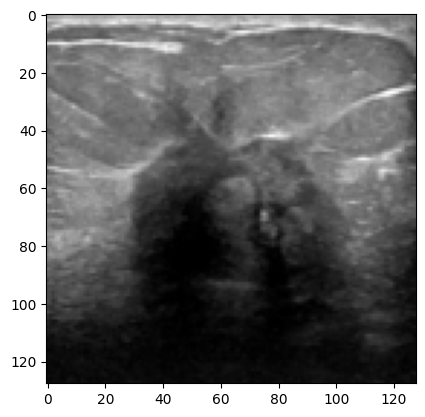

In [ ]:
# seperate by label
malignant_imgs = egypt_x[egypt_y == 0]  # label 0
benign_imgs = egypt_x[egypt_y == 1]     # label 1
# output an image
print(f"Number of malignant images: {len(malignant_imgs)}")
print(f"Number of benign images: {len(benign_imgs)}")
#output with plt
import matplotlib.pyplot as plt
plt.imshow(malignant_imgs[0], cmap='gray')
plt.show()

In [ ]:
# count the number of images in /content/egypt_benign
benign_count = len(os.listdir("/content/egypt_benign_real"))
malignant_count = len(os.listdir("/content/egypt_malignant_real"))
print(f"Number of benign images: {benign_count}")
print(f"Number of malignant images: {malignant_count}")

Number of benign images: 570
Number of malignant images: 210


In [ ]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN.git

Cloning into 'PyTorch-GAN'...
remote: Enumerating objects: 1283, done.
remote: Total 1283 (delta 0), reused 0 (delta 0), pack-reused 1283 (from 1)
Receiving objects: 100% (1283/1283), 68.04 MiB | 15.79 MiB/s, done.
Resolving deltas: 100% (751/751), done.


In [ ]:
from torchvision import transforms

In [ ]:
!ls /content/egypt_malig_big_gan2/

0.png	 120.png  141.png  162.png  183.png  23.png  44.png  65.png  86.png
100.png  121.png  142.png  163.png  184.png  24.png  45.png  66.png  87.png
101.png  122.png  143.png  164.png  185.png  25.png  46.png  67.png  88.png
102.png  123.png  144.png  165.png  186.png  26.png  47.png  68.png  89.png
103.png  124.png  145.png  166.png  187.png  27.png  48.png  69.png  8.png
104.png  125.png  146.png  167.png  188.png  28.png  49.png  6.png   90.png
105.png  126.png  147.png  168.png  189.png  29.png  4.png   70.png  91.png
106.png  127.png  148.png  169.png  18.png   2.png   50.png  71.png  92.png
107.png  128.png  149.png  16.png   190.png  30.png  51.png  72.png  93.png
108.png  129.png  14.png   170.png  191.png  31.png  52.png  73.png  94.png
109.png  12.png   150.png  171.png  192.png  32.png  53.png  74.png  95.png
10.png	 130.png  151.png  172.png  193.png  33.png  54.png  75.png  96.png
110.png  131.png  152.png  173.png  194.png  34.png  55.png  76.png  97.png
111.png  132.png

In [ ]:
#make dir for benign
os.makedirs("/content/benign_collect", exist_ok=True)  # samples we want

In [ ]:
os.makedirs("/content/benign_not_collect", exist_ok=True) # samples we dont

In [ ]:
!python /content/PyTorch-GAN/implementations/wgan/wgan.py # run their code, I changed code in their file first, moved it over for comments.

/content/PyTorch-GAN/implementations/wgan/wgan.py:215: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
[Epoch 0/500] [Batch 0/18] [D loss: -0.1026] [G loss: 0.0033]
[Epoch 0/500] [Batch 3/18] [D loss: -0.0153] [G loss: 0.0030]
[Epoch 0/500] [Batch 6/18] [D loss: -0.0318] [G loss: 0.0024]
[Epoch 0/500] [Batch 9/18] [D loss: -0.0470] [G loss: 0.0008]
[Epoch 0/500] [Batch 12/18] [D loss: -0.0607] [G loss: -0.0089]
[Epoch 0/500] [Batch 15/18] [D loss: -0.0974] [G loss: 0.0355]
[Epoch 1/500] [Batch 0/18] [D loss: -0.2475] [G loss: 0.1365]
[Epoch 1/500] [Batch 3/18] [D loss: -0.4026] [G loss: 0.2153]
[Epoch 1/500] [Batch 6/18] [D loss: 0.0606] [G loss: 0.0118]
[Epoch 1/500] [Batch 9/18] [D loss: -0.6143] [G loss: 

ideas: dropout, noise addition

In [ ]:
!zip -r egypt_benign_big_gan_final.zip /content/egypt_benign_BIG-GAN_final # download our data

  adding: content/egypt_benign_BIG-GAN_final/ (stored 0%)
  adding: content/egypt_benign_BIG-GAN_final/29.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/127.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/184.png (deflated 1%)
  adding: content/egypt_benign_BIG-GAN_final/159.png (deflated 1%)
  adding: content/egypt_benign_BIG-GAN_final/61.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/51.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/108.png (deflated 1%)
  adding: content/egypt_benign_BIG-GAN_final/27.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/22.png (deflated 1%)
  adding: content/egypt_benign_BIG-GAN_final/75.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/134.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/178.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/38.png (deflated 0%)
  adding: content/egypt_benign_BIG-GAN_final/40.png (deflated 0%)
  adding: co

In [ ]:
from google.colab import files
files.download("egypt_benign_big_gan_final.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here is the modified version inside of /content/PyTorch-GAN/implementations/wgan/wgan.py

In [ ]:
# some default arguments from the code, we changed epoch, batch_size, lr, latent_dim, critic, and clip_value a few times each
class Args:
    n_epochs = 2000
    batch_size = 32
    lr = 0.00005
    n_cpu = 2
    latent_dim = 100
    img_size = 128
    channels = 1
    n_critic = 5
    clip_value = 0.01
    sample_interval = 50

opt = Args()

In [ ]:
# image shape.. more default code from github.
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
# egypt dataset paths from the loader
malignant_dir = "/content/egypt_malignant_real"
benign_dir = "/content/egypt_benign_real"

In [ ]:
# tanh normalization (does better I think)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

In [ ]:
# get data from content to move to the loader
def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).convert("L")
            img = transform(img)
            images.append(img)
    return torch.stack(images)

In [ ]:


# choose data to generate, malignant or benign
train_class = "malignant"

if train_class == "malignant":
    selected_images = load_images_from_directory(malignant_dir)
elif train_class == "benign":
    selected_images = load_images_from_directory(benign_dir)
else:
    raise ValueError("train_class must be 'malignant' or 'benign'")

# data loader from file above
dataset = TensorDataset(selected_images)
dataloader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)

In [ ]:
# The generator model, most of this is from the github
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.init_size = 8
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),

            # more convolutions at each level
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, opt.channels, 3, 1, 1),
            nn.Tanh()
        )
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
# Discriminator, named as critic in the WGAN paper, changed a bit more than the generator, also from the github
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_filters, out_filters, downsample=True):
            layers = [
                # add spectral norm, stabilizes the gradient
                nn.utils.spectral_norm(nn.Conv2d(in_filters, out_filters, 3, 1, 1)),
                nn.LeakyReLU(0.2, inplace=True),
                nn.utils.spectral_norm(nn.Conv2d(out_filters, out_filters, 4, 2 if downsample else 1, 1)),
                nn.BatchNorm2d(out_filters),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            return layers

        self.model = nn.Sequential(
            *block(opt.channels, 32),
            *block(32, 64),
            *block(64, 128),
            *block(128, 256),
            nn.utils.spectral_norm(nn.Conv2d(256, 1, 3, 1, 1))
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [ ]:
# initalize the models
generator = Generator().cuda() if cuda else Generator()
discriminator = Discriminator().cuda() if cuda else Discriminator()

In [ ]:
# we did not like how RMS or SGD did, we kept Adam
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

#optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
#optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

In [ ]:

# GPT helped a lot here!
# we start saving at 1000 epochs (might be a horrible idea actually, my understanding is we generate from a distribution, but it is what it is)
saved_images = 0
total_to_save = 200
start_epoch = 1000
end_epoch = opt.n_epochs
save_interval = ((end_epoch - start_epoch) * len(dataloader)) // total_to_save

batches_done = 0
for epoch in range(opt.n_epochs):
    for i, (imgs,) in enumerate(dataloader):

        real_imgs = Variable(imgs.type(Tensor))


        optimizer_D.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        fake_imgs = generator(z).detach()

        real_pred = discriminator(real_imgs)
        fake_pred = discriminator(fake_imgs)
        # distance that the critic (discriminator) from means of the images
        loss_D = -torch.mean(real_pred) + torch.mean(fake_pred)

        loss_D.backward()
        optimizer_D.step()
        # gradient clipping helps discriminator not go crazy
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)

        if i % opt.n_critic == 0:
            optimizer_G.zero_grad()
            gen_imgs = generator(z)
            fake_pred_gen = discriminator(gen_imgs)
            loss_G = -torch.mean(fake_pred_gen)
            loss_G.backward()
            optimizer_G.step()

            print(
                f"[Epoch {epoch}/{opt.n_epochs}] [Batch {i}/{len(dataloader)}] "
                f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]"
            )

        # save images at 1000 epochs
        # 2000 epochs sounds like a lot, but for out small dataset it ran fine, but probably should use way less epochs still
        # 2000 epochs is a little absurd
        if epoch >= start_epoch and saved_images < total_to_save:
            if (batches_done - (start_epoch * len(dataloader))) % save_interval == 0:
                for idx, img in enumerate(gen_imgs[:1]):  # Save 1 image at a time
                    save_image(img, f"egypt_malig_BIG-GAN_final/{saved_images}.png", normalize=True)
                    saved_images += 1
                    if saved_images >= total_to_save:
                        break

        batches_done += 1